# GramCAM for Evaluating Brain Tumor MRIs

by Christian Moreira

Duke University

AIPI 590 - Explainable AI - Fall 2025

[![Open In Colab](https://img.shields.io/badge/Open%20In-Colab-F9AB00.svg?logo=googlecolab&style=for-the-badge)](https://colab.research.google.com/github/U1186204/GradCAM-in-Brain-Tumor-Classification/blob/main/main.ipynb)

[![GitHub Repo](https://img.shields.io/badge/GitHub-Repo-black.svg?logo=github&style=for-the-badge)](https://github.com/U1186204/GradCAM-in-Brain-Tumor-Classification/tree/main)


#### Importing Packages

In [2]:
# Importing Key Packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")



#### Loading Dataset

In [3]:
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


#### Dataframe Formation

In [4]:
def create_dataframe(base_path):
    """
    Scans the directory structure (Class/Image) and creates a DataFrame
    with image paths and their corresponding class labels.
    """
    classes = []
    class_paths = []

    for label in os.listdir(base_path):
        label_path = os.path.join(base_path, label)

        if os.path.isdir(label_path):
            for image in os.listdir(label_path):
                image_path = os.path.join(label_path, image)

                classes.append(label)
                class_paths.append(image_path)

    df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return df

print("Data loading functions defined.")

Data loading functions defined.


#### Splitting Data into Train/Test Sets

In [5]:
tr_path = os.path.join(path, 'Training')
ts_path = os.path.join(path, 'Testing')

tr_df = create_dataframe(tr_path)
ts_df = create_dataframe(ts_path)

print("Training Data:")
print(tr_df.head())
print(f"\nTraining DataFrame Shape: {tr_df.shape}")

Training Data:
                                          Class Path      Class
0  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
1  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
2  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
3  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
4  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary

Training DataFrame Shape: (5712, 2)


#### Brain MRI Distributions in Train and Test Sets

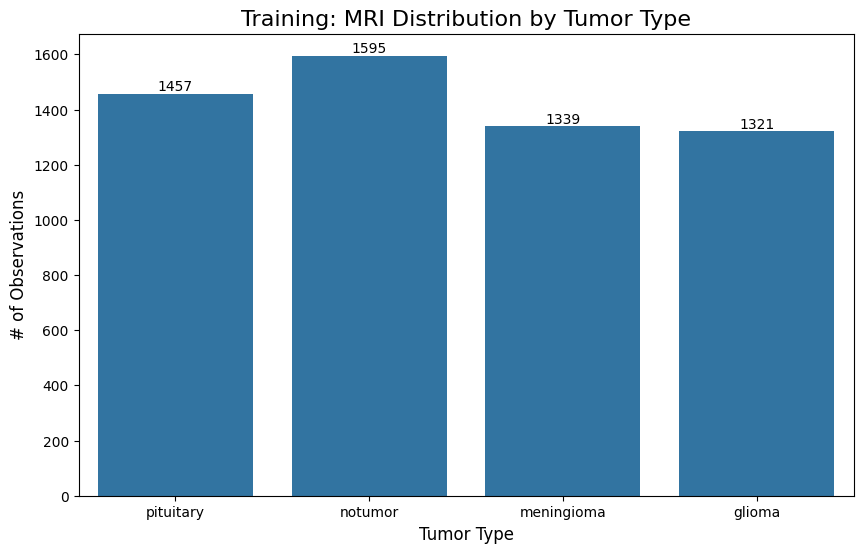

In [6]:

plt.figure(figsize=(10, 6))
ax = sns.countplot(data=tr_df, x='Class')

plt.title('Training: MRI Distribution by Tumor Type', fontsize=16)
plt.xlabel('Tumor Type', fontsize=12)
plt.ylabel('# of Observations', fontsize=12)

ax.bar_label(ax.containers[0])
plt.show()

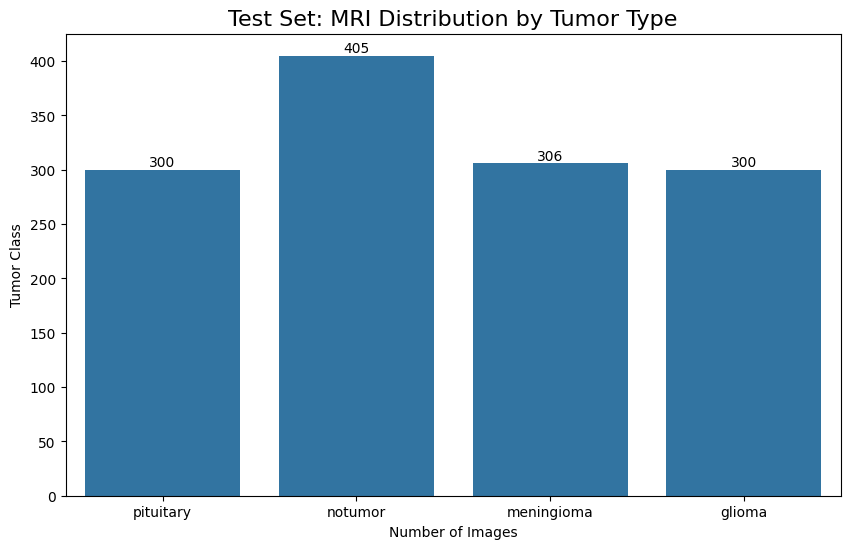

In [7]:

plt.figure(figsize=(10, 6))
ax = sns.countplot(data=ts_df, x='Class')

plt.title('Test Set: MRI Distribution by Tumor Type', fontsize=16)
plt.xlabel('Number of Images')
plt.ylabel('Tumor Class')

ax.bar_label(ax.containers[0])
plt.show()

#### Splitting Data into Train - Test - Validation Sets

In [8]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=42, stratify=ts_df['Class'])

In [9]:
valid_df.head()

,Class Path,Class
537,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
734,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
470,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
1169,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
996,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma


#### Pre-Processing MRI Images in Train-Test-Validation Sets

In [10]:
batch_size = 32
img_size = (299,299)

_gen = ImageDataGenerator(
    rescale=1/255,
    brightness_range=(0.8,1.2)
    )

ts_gen = ImageDataGenerator(rescale=1/255)

tr_gen = _gen.flow_from_dataframe(dataframe = tr_df, x_col='Class Path', y_col='Class', batch_size=batch_size, target_size=img_size)

valid_gen = _gen.flow_from_dataframe(dataframe = valid_df, x_col='Class Path', y_col='Class', batch_size=batch_size, target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(dataframe = ts_df, x_col='Class Path', y_col='Class', batch_size=16, target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


#### Observing Tumor Samples

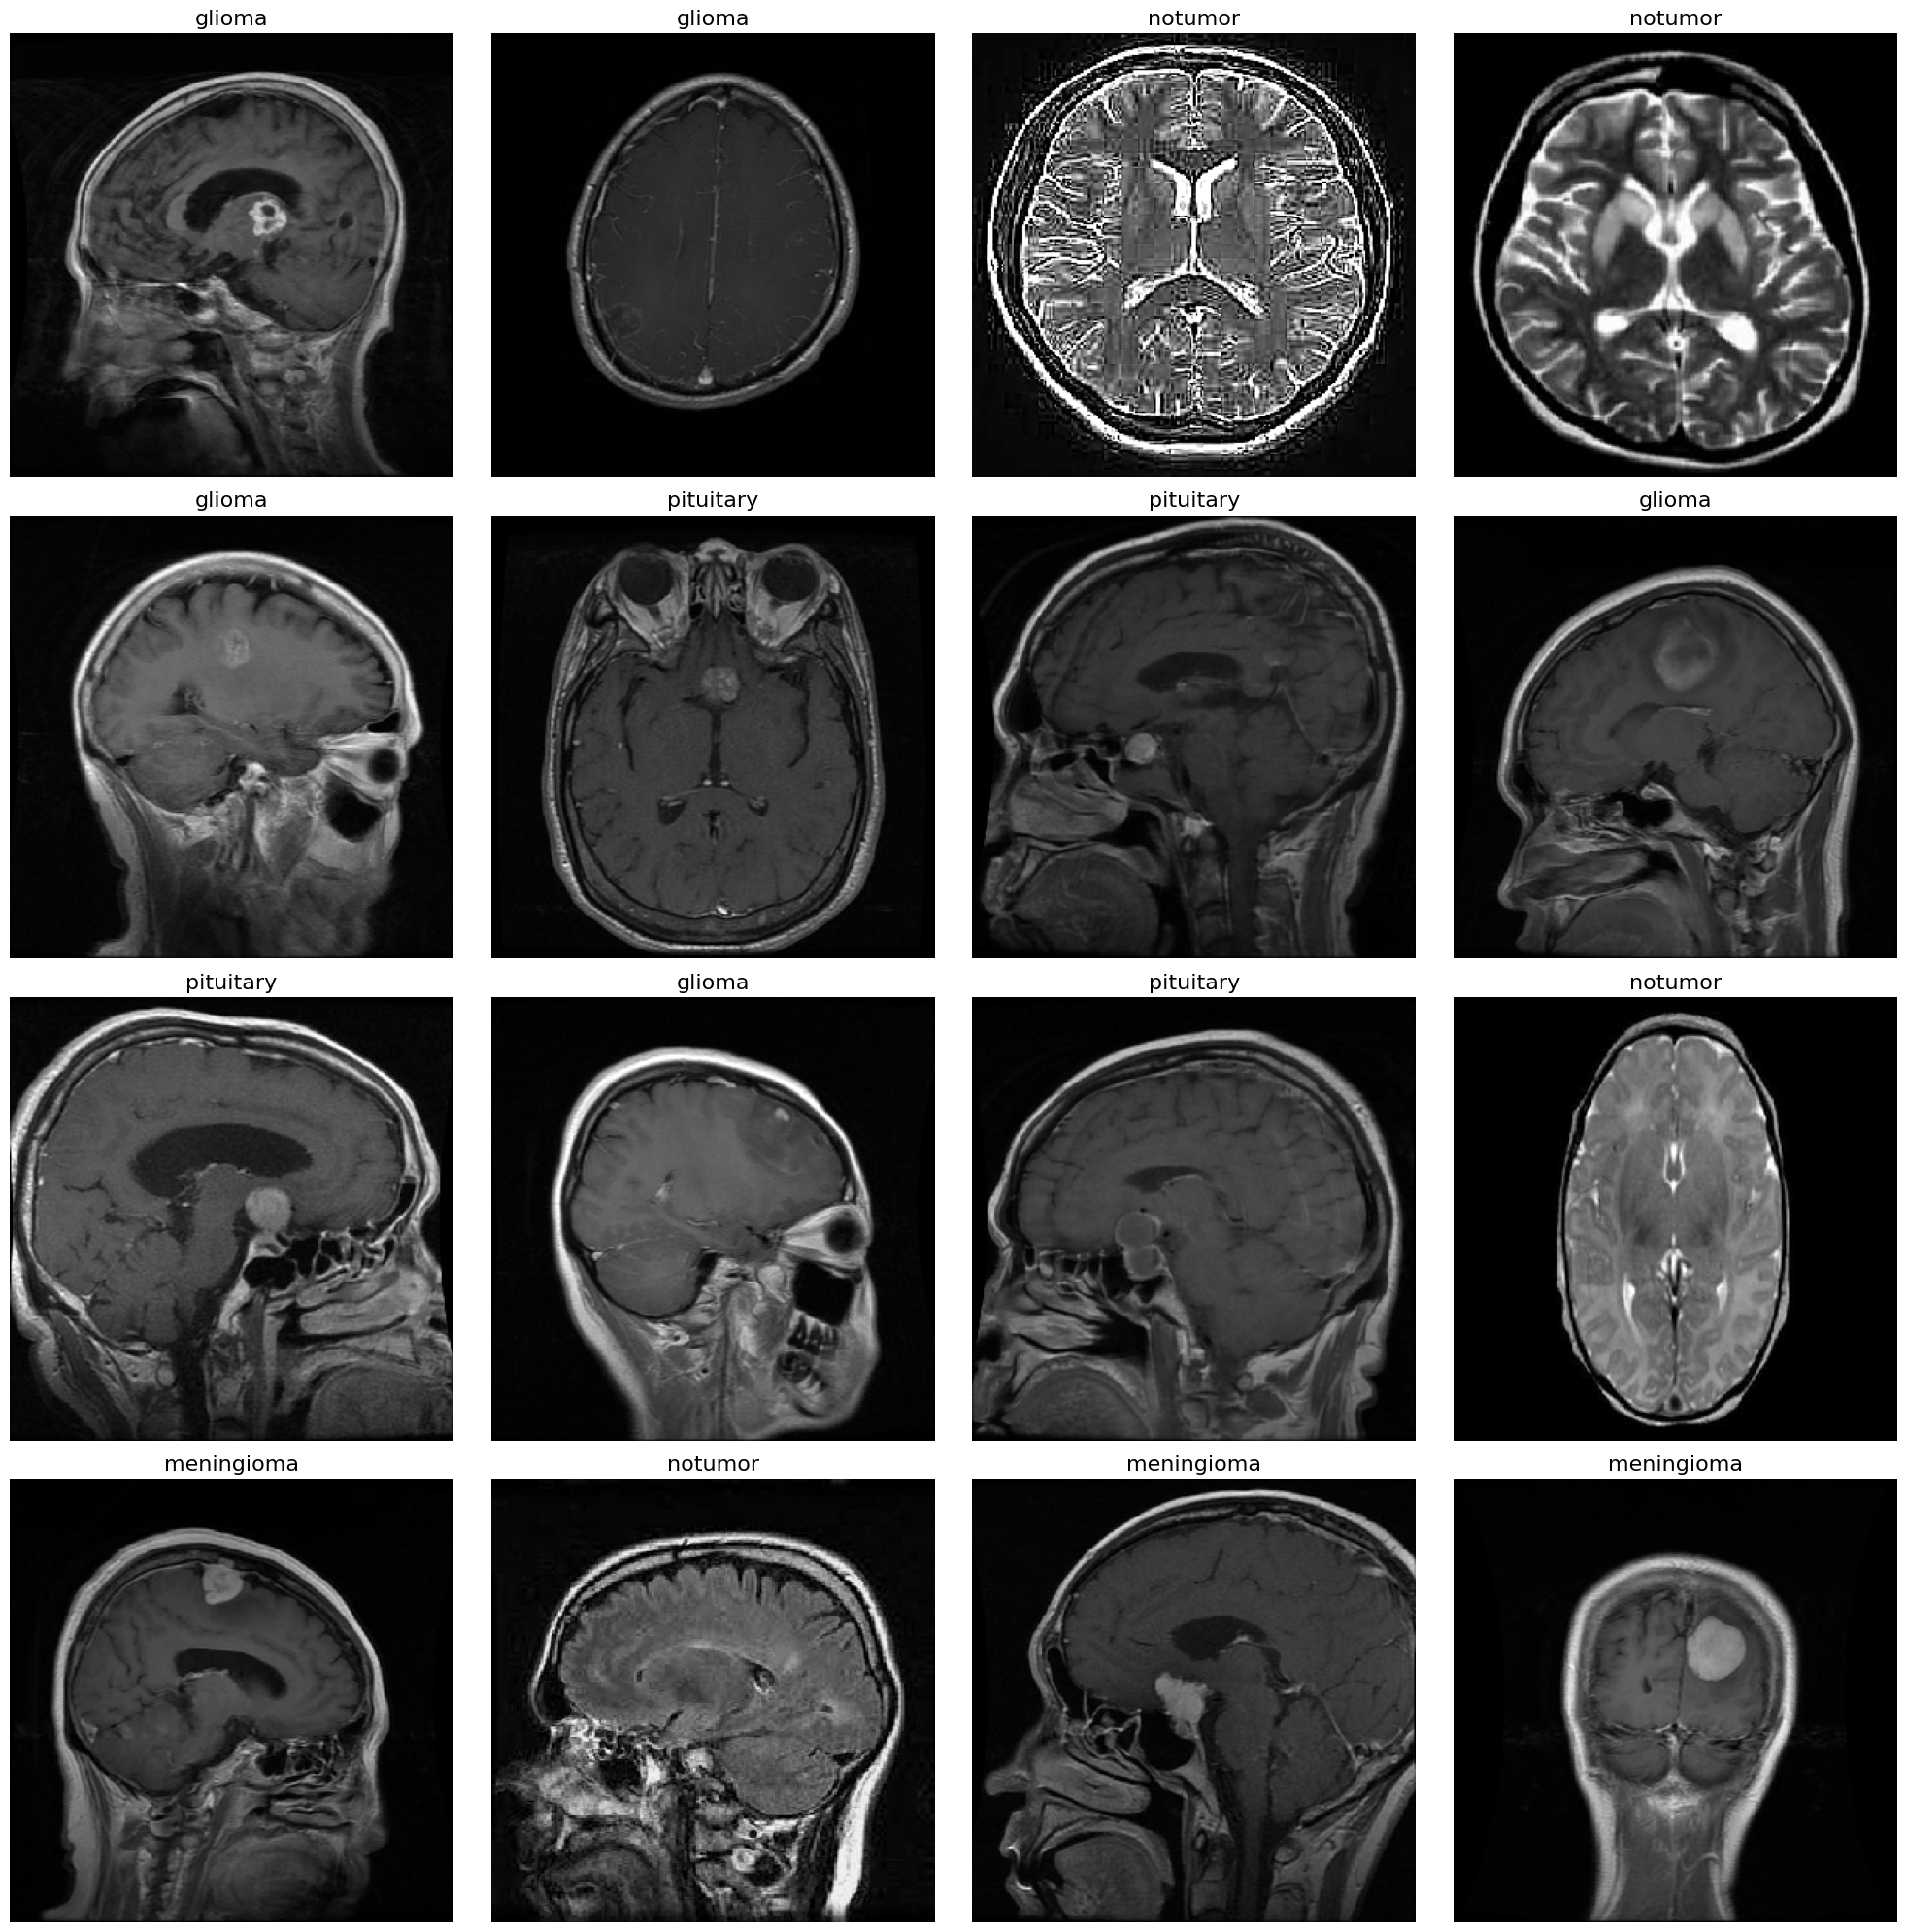

In [11]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(tr_gen)

plt.figure(figsize=(20, 20))

for i in range(16):
    if i >= len(images):
        break

    image = images[i]
    label = labels[i]

    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)

    if label.ndim > 0:
        class_index = np.argmax(label)
    else:
        class_index = int(label)

    class_name = classes[class_index]

    plt.title(class_name, color='k', fontsize=16)
    plt.axis('off')

plt.tight_layout()
plt.show()

#### Deep Learning Model

In [12]:
img_shape = (299, 299, 3)
base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_shape = img_shape, pooling= 'max')

model = Sequential(
    [
        base_model,
        Flatten(),
        Dropout(rate = 0.3),
        Dense(128, activation='relu'),
        Dropout(rate = 0.25),
        Dense(4, activation='softmax')
    ]
)

model.compile(
    Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

model.summary()


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

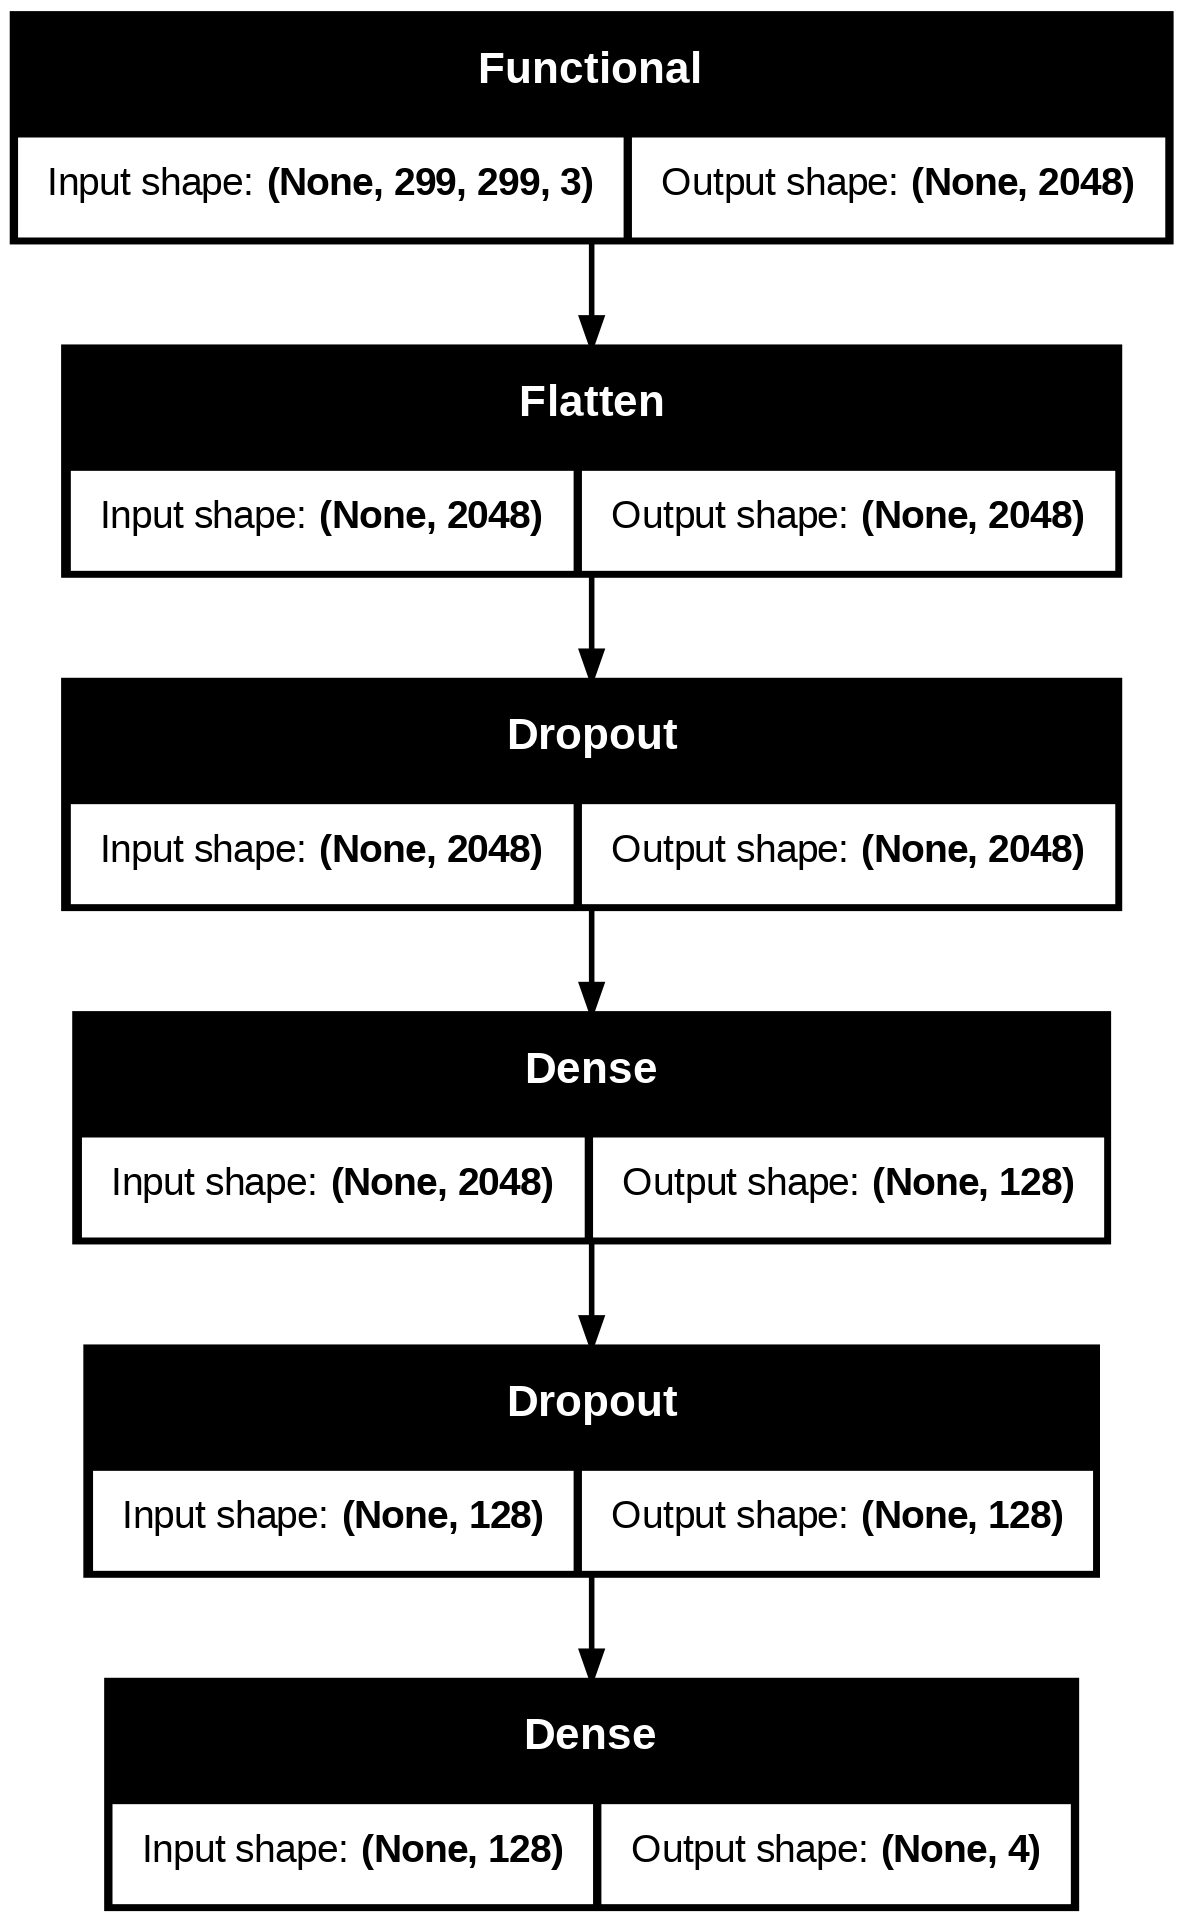

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True)

#### Training Model on Data

In [15]:
hist = model.fit(tr_gen,
                 epochs=10,
                 validation_data= valid_gen,
                 shuffle=False)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 351s 1s/step - accuracy: 0.6312 - loss: 0.9734 - precision: 0.7300 - recall: 0.4021 - val_accuracy: 0.6947 - val_loss: 1.5213 - val_precision: 0.6989 - val_recall: 0.6840
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 148s 826ms/step - accuracy: 0.9719 - loss: 0.0841 - precision: 0.9731 - recall: 0.9697 - val_accuracy: 0.9603 - val_loss: 0.1149 - val_precision: 0.9661 - val_recall: 0.9573
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 147s 823ms/step - accuracy: 0.9937 - loss: 0.0175 - precision: 0.9940 - recall: 0.9932 - val_accuracy: 0.9817 - val_loss: 0.0597 - val_precision: 0.9847 - val_recall: 0.9817
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 148s 824ms/step - accuracy: 0.9969 - loss: 0.0120 - precision: 0.9971 - recall: 0.9962 - val_accuracy: 0.9939 - val_loss: 0.0273 - val_precision: 0.9939 - val_recall: 0.9939
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 147s 823ms/step - accuracy: 0.9966 - loss: 0.0108 - precision: 0.9967 - recall: 0.9966 - val_accuracy: 0.96

#### Model Performance

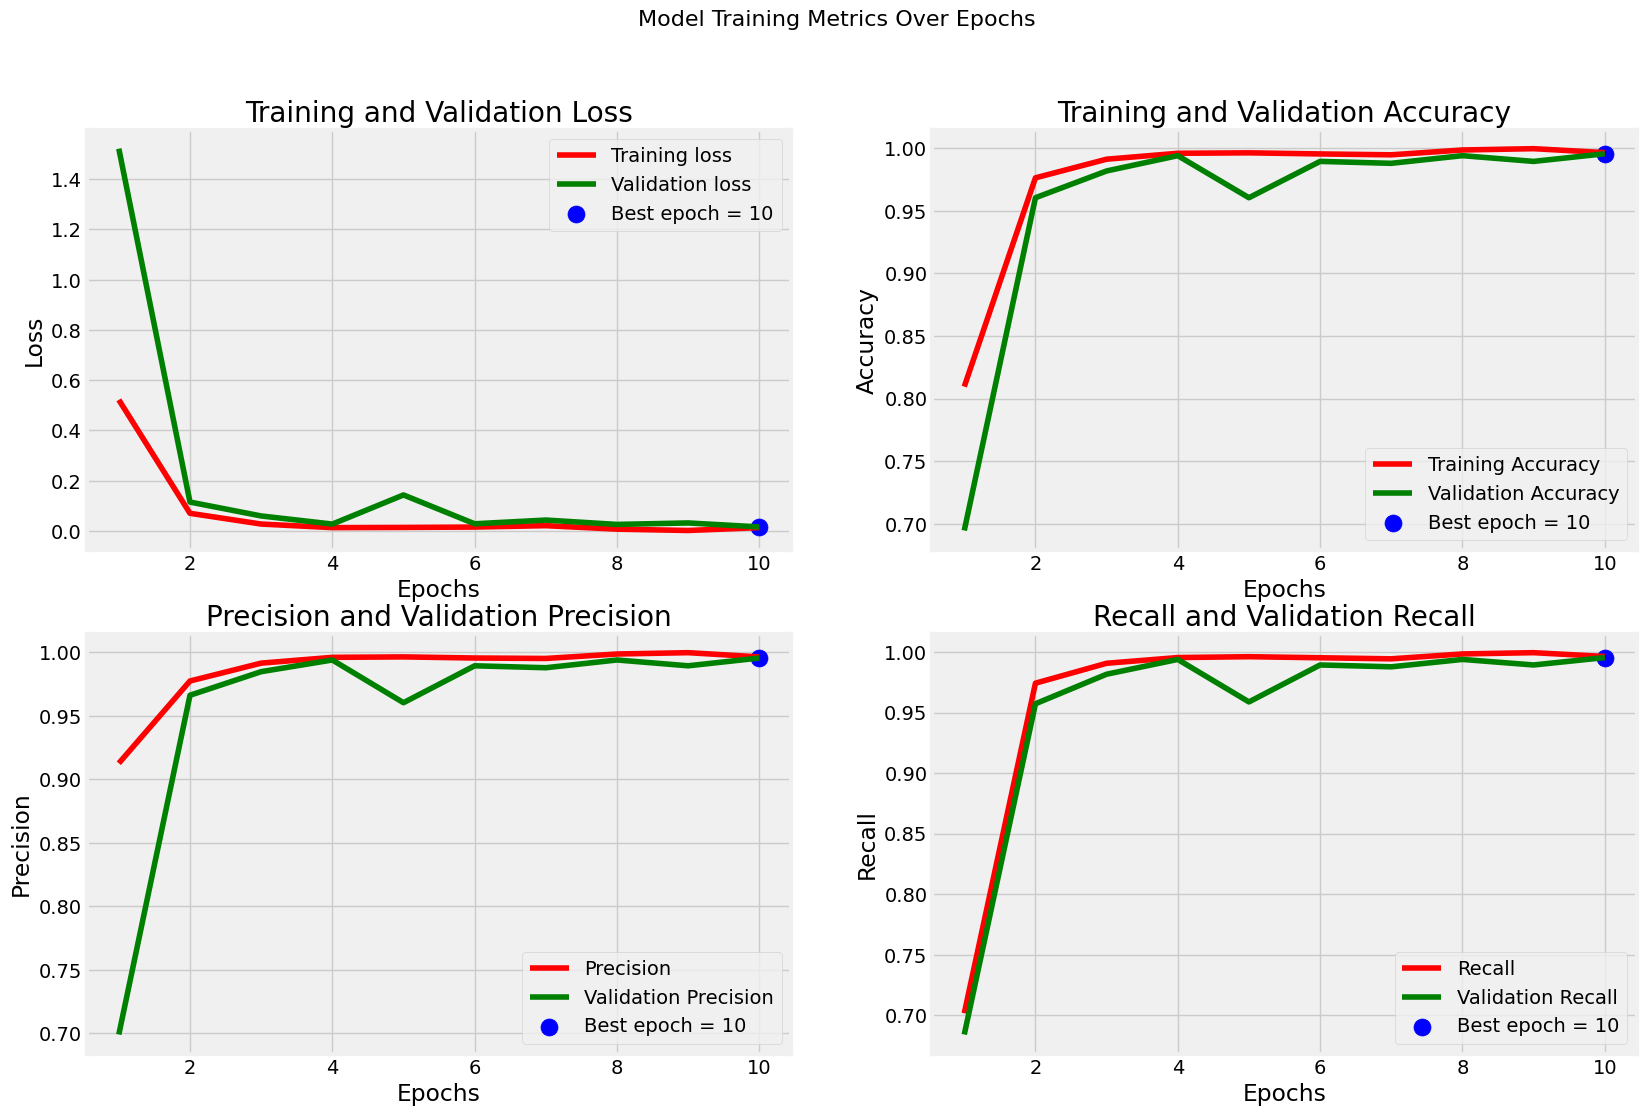

In [16]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

#### Evaluation

In [17]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

179/179 ━━━━━━━━━━━━━━━━━━━━ 54s 299ms/step - accuracy: 0.9998 - loss: 0.0012 - precision: 0.9998 - recall: 0.9998
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 315ms/step - accuracy: 0.9883 - loss: 0.0514 - precision: 0.9883 - recall: 0.9883
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.9950 - loss: 0.0167 - precision: 0.9950 - recall: 0.9950
Train Loss: 0.0033
Train Accuracy: 99.96%
--------------------
Validation Loss: 0.0208
Validation Accuracy: 99.54%
--------------------
Test Loss: 0.0286
Test Accuracy: 99.39%


In [18]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 110ms/step


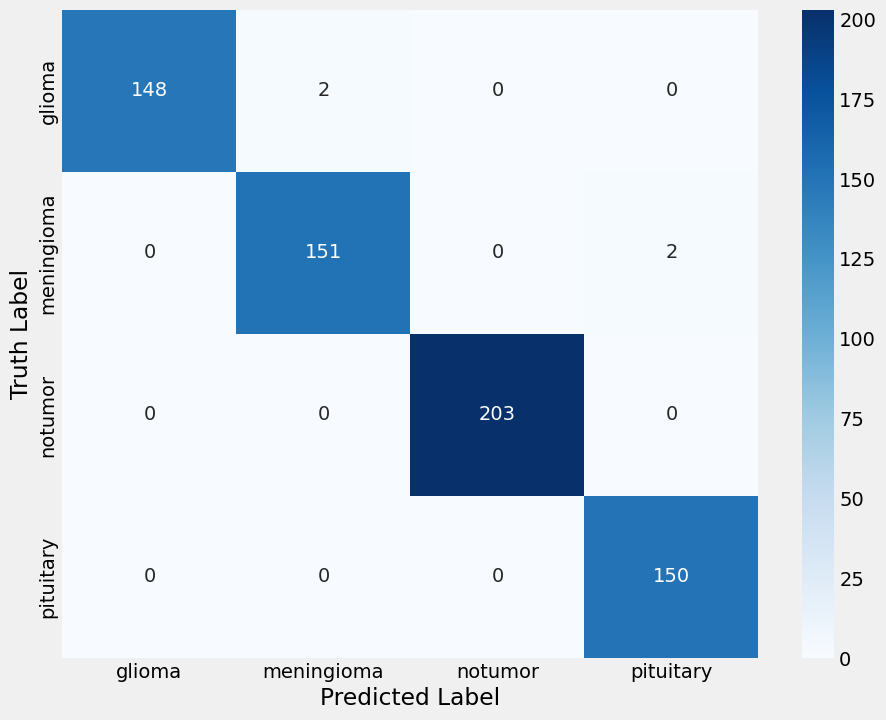

In [19]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [20]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       150
           1       0.99      0.99      0.99       153
           2       1.00      1.00      1.00       203
           3       0.99      1.00      0.99       150

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



#### Testing

In [21]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step


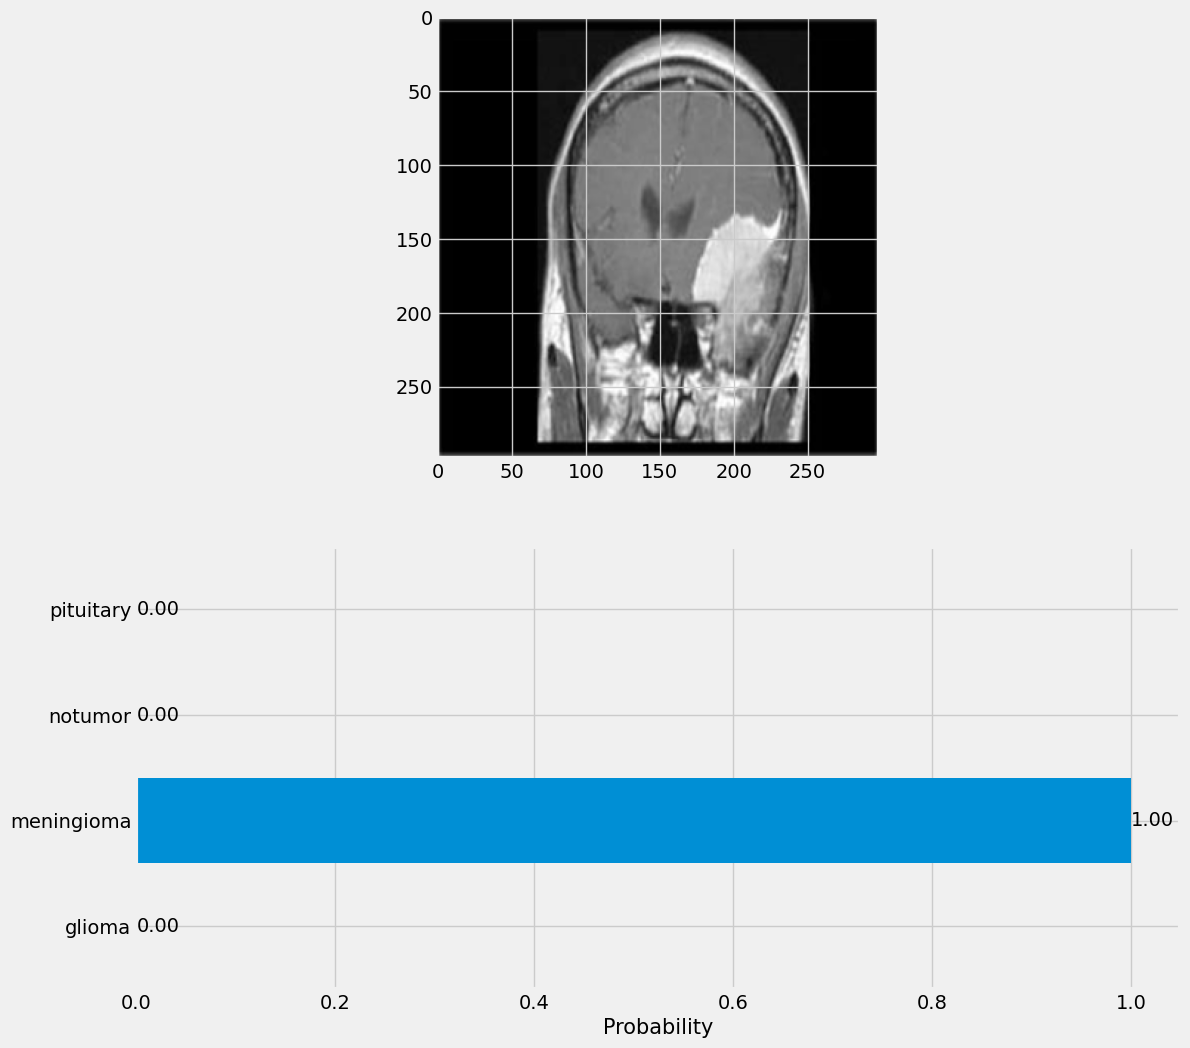

In [22]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-meTr_0000.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


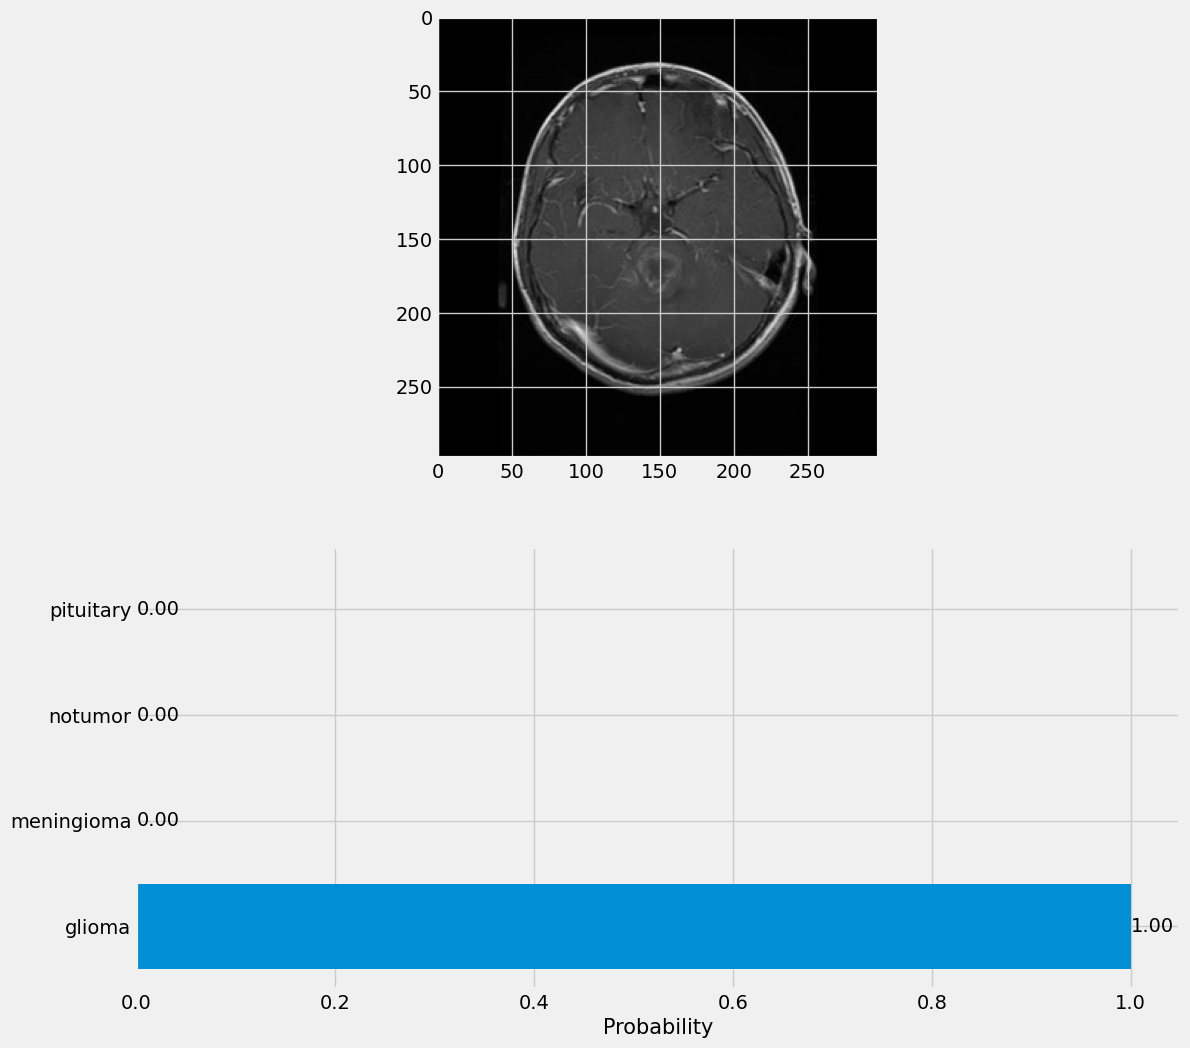

In [23]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-glTr_0007.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


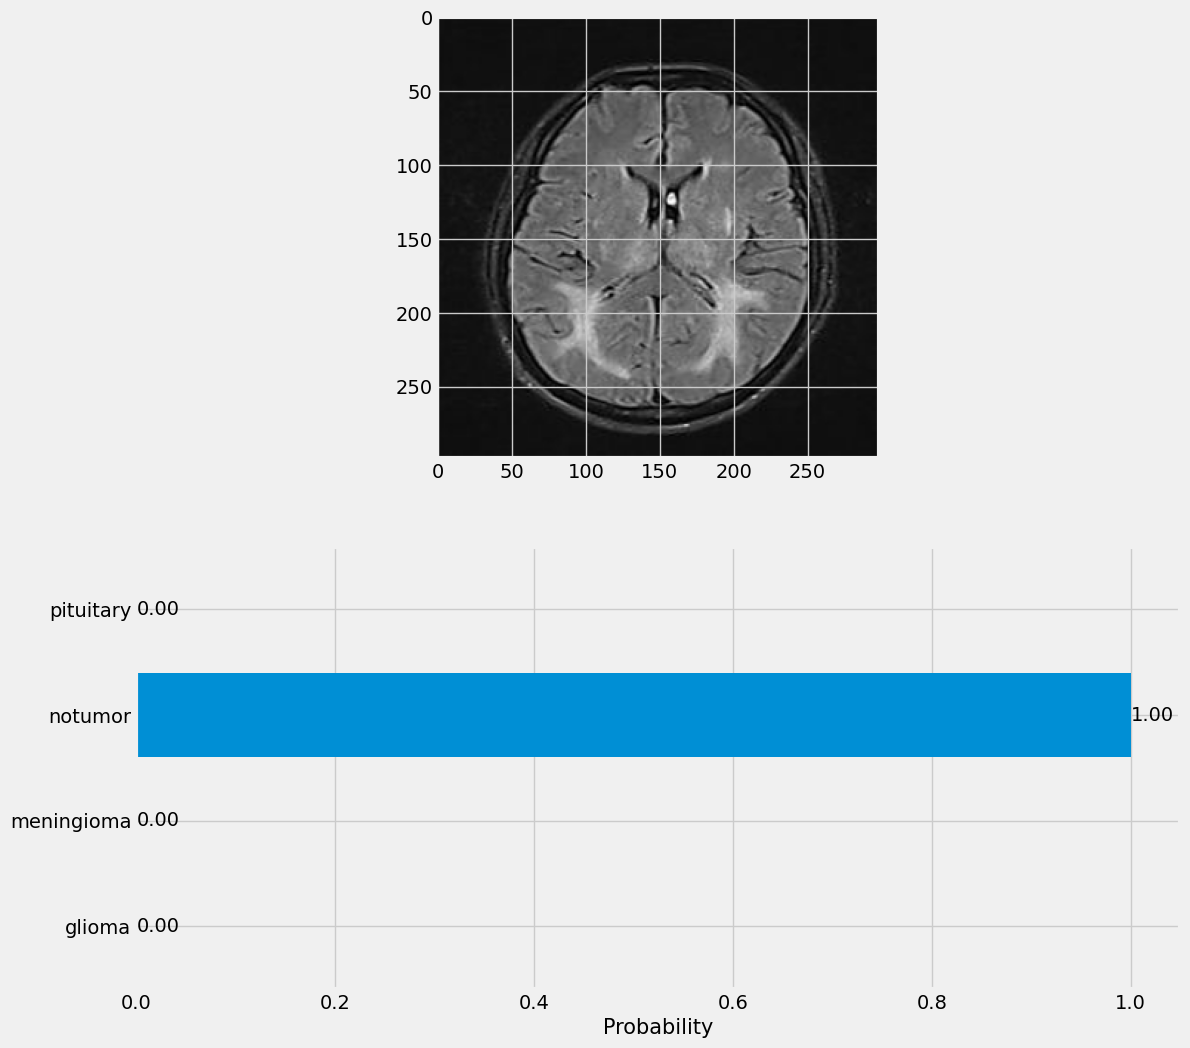

In [24]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-noTr_0001.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


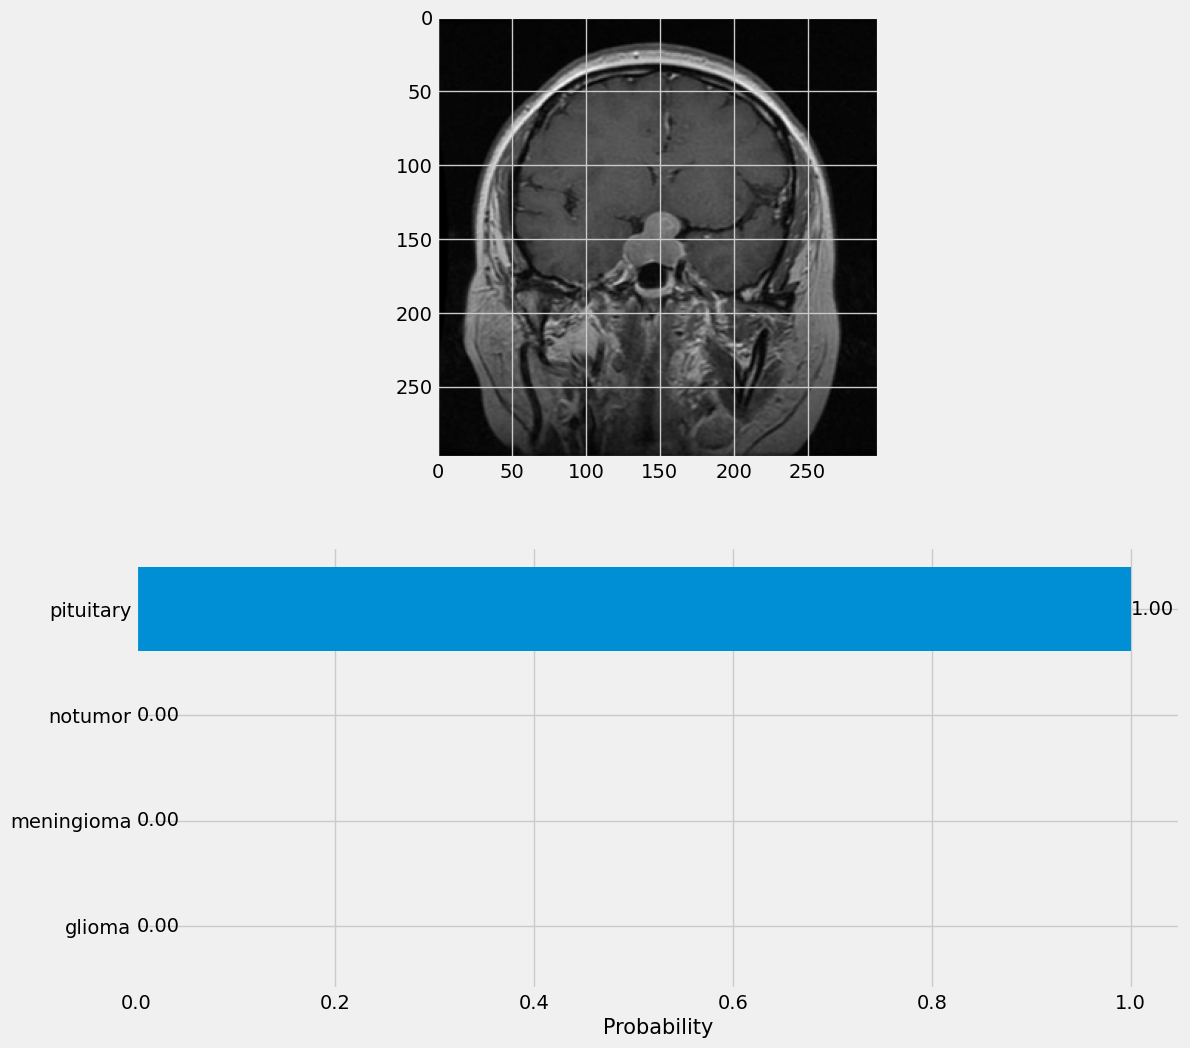

In [25]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-piTr_0001.jpg')